In [1]:
using LinearAlgebra, Random, Statistics, Plots

# Weak random features

Here we'll generate data using the so-called weak random features model:

1. the first `num_informative_features` features are noisy versions of the label `y`
2. the rest of the features are pure noise 

We're interested in understanding the optimal model complexity as a function of the number of features we choose, in each of these models.

## Questions

1. How does the optimal model complexity depend on the noise in the features?
2. When does the error curve exhibit a "double descent" behavior? When is the best model found on the first descent vs the second descent?
3. How does this phenomenon depend on the choice of optimizer / regularizer, for underconstrained problems?

In [2]:
function random_features(n=100,d=100; num_informative_features = 20)
    y = randn(n)
    X = randn(n,min(d,num_informative_features)) .+ y
    if d > num_informative_features
        X = hcat(X, randn(n,d - num_informative_features))
    end
    return X,y
end

random_features (generic function with 3 methods)

  3.240060 seconds (5.32 M allocations: 631.365 MiB, 8.83% gc time)


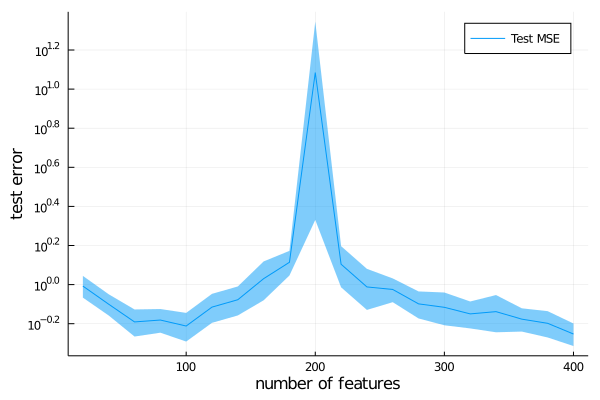

In [3]:
n = 200
ds=20:20:2n
num_informative_features = 100 # try 10, 100, 1000
nreps = 10

mses = zeros(length(ds),nreps)
train_errors = zeros(length(ds),nreps)
@time for rep in 1:nreps
    mse = []
    train_error = []
    for d in ds
        Xtrain,ytrain = random_features(n,d; num_informative_features=num_informative_features)
        w = Xtrain\ytrain
        Xtest,ytest = random_features(Int(n/10),d; num_informative_features=num_informative_features)
        push!(mse, norm(ytest-Xtest*w))
        push!(train_error, norm(ytrain-Xtrain*w))
    end
    mses[:,rep] = mse
    train_errors[:,rep] = train_error
end
mean_mse = mean(mses,dims=2)
std_mse = std(mses,dims=2)
mean_te = mean(train_errors,dims=2)
std_te = std(train_errors,dims=2)

std_mse = min.(std_mse,.9mean_mse) # a hack to ensure we don't try to plot a negative number on a log plot
std_te = min.(std_te,.9mean_te) # a hack to ensure we don't try to plot a negative number on a log plot
plot(ds,mean_mse,ribbon=std_mse,label="Test MSE")
# plot!(ds,mean_te,ribbon=std_te,label="Train MSE")
yaxis!(:log)
ylabel!("test error")
xlabel!("number of features")

## Observations: 

1. The error blows up as $d \to n$.
2. With 10 informative features, the best test error occurs for d as small as possible.
3. With 100 informative features, the best test error occurs around d=100.
4. When all features are informative, the best test error occurs as $d \to \infty$ (or, at least, as large as we tested).

# MNIST

MNIST is a dataset of images with 784 grayscale pixels, representing digits. We will be fitting classifiers to this dataset, and hopefully recovering the double descent curve.

Instead of operating on the pixels direclty, we are going to use a ReLU features: that is, we will take a random matrix, then use it to transform the raw pixels into $d$ features. We will throw away all the nonnegative numbers beceause this makes our initial transformation nonlinear, which actually makes the entire model more expressive (this is common practice in deep nets, although we are not training the first layer at all).

We use a procedure with decaying gradient stepsize, and play with regularizers as well (everything except the regularizers is usable, but the regularizers are a little hacky; we recommend other example code provided in this class).

Let's first load the data, then write up all the utility functions necessary.

In [4]:
# read data 
using MLDatasets, ImageCore

_, ytrain = MNIST.traindata()
_,  ytest  = MNIST.testdata()

# Xtrain = MNIST.convert2features(Xtrain)'
# Xtest = MNIST.convert2features(Xtest)'

Xtrain = convert(Array{Float64}, reshape(MNIST.traintensor(), 28*28, :)');
Xtest = convert(Array{Float64}, reshape(MNIST.testtensor(), 28*28, :)');

In [5]:
# Xtrain = MNIST.convert2features(Xtrain)'

In [6]:
# view training data as images; eg the 5th example:
MNIST.convert2image(MNIST.traintensor(5))

In [7]:
function convert2psi(ys, n = 10)
    psis = -1.0*ones(length(ys), n)
    for i in 1:length(ys)
        psis[i, ys[i] + 1] = 1.0
    end
    return psis
end

psiTrain = convert2psi(ytrain)
psiTest = convert2psi(ytest)

10000×10 Array{Float64,2}:
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0
 -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
  1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0
 -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0
  1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0
  ⋮                             ⋮                      
 -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0

In [8]:
ReLU(x) = max(x,0)

struct RandomFeatureMap
    W::AbstractArray
end
RandomFeatureMap(din,dout) = RandomFeatureMap(randn(din,dout))

function featurize(X,M::RandomFeatureMap)
    return ReLU.(X*M.W)
end

featurize (generic function with 1 method)

In [9]:
function hinge(ys, preds)
    return ReLU.((-ys.*preds).+1)
end

function hingeDerivative(ys, preds)
    return sign.(hinge(ys, preds)).*(-ys)
end

function linDerivatives(X, outDers)
    bDer = zeros(size(outDers)[2])
    WDer = zeros(size(outDers)[2]).*transpose(zeros(size(X)[2]))
    for i in 1:(size(X)[1])
        bDer += outDers[i, :]
        WDer += outDers[i, :].*transpose(X[i, :])
    end
    return WDer, bDer
end

linDerivatives (generic function with 1 method)

In [10]:
function predictedClass(preds)
    _, h = findmax(preds, dims=2)
    ypred = [element[2] - 1 for element in h]
    return ypred
end

function accuracy(y, ypred)
    # Unlike the other losses, this one takes the actual class labels as input, not the transformed inputs (psis)
    return sum(y.==ypred)/length(y)
end

accuracy (generic function with 1 method)

We are now ready to try to fit the model using gradient descent, using either more or fewer features than training data. We will fit using L2 loss (backslash) and look directly at the test accuracy.

In [11]:
ntrain=500
ntest=500
Xtrain_samp = Xtrain[1:ntrain,:]
psiTrain_samp = psiTrain[1:ntrain,:]
ytrain_samp = ytrain[1:ntrain]
Xtest_samp = Xtest[1:ntest,:]
psiTest_samp = psiTest[1:ntest,:]
ytest_samp = ytest[1:ntest]
din = size(Xtrain_samp,2)
ds=100:100:1500
nreps = 4

accs_back = zeros(length(ds),nreps)
@time for rep in 1:nreps
    acc = []
    for dout in ds
        println(dout)
        # select random features
        M = RandomFeatureMap(din,dout)
        
        # train
        phiXtrain = featurize(Xtrain_samp,M)
        #W, b = gradDescent(phiXtrain, psiTrain_samp, ytrain_samp, 1000, 0.1, true)
        w0 = phiXtrain\psiTrain_samp[:, 1]
        w1 = phiXtrain\psiTrain_samp[:, 2]
        w2 = phiXtrain\psiTrain_samp[:, 3]
        w3 = phiXtrain\psiTrain_samp[:, 4]
        w4 = phiXtrain\psiTrain_samp[:, 5]
        w5 = phiXtrain\psiTrain_samp[:, 6]
        w6 = phiXtrain\psiTrain_samp[:, 7]
        w7 = phiXtrain\psiTrain_samp[:, 8]
        w8 = phiXtrain\psiTrain_samp[:, 9]
        w9 = phiXtrain\psiTrain_samp[:, 10]
        
        W = hcat(w0, w1, w2, w3, w4, w5, w6, w7, w8, w9)
        #w = phiXtrain\ytrain_samp
        
        # test
        phiXtest = featurize(Xtest_samp,M)
        acc_new = accuracy(ytest_samp, predictedClass(phiXtest*W))
        println(acc_new)
        push!(acc, acc_new)
    end
    accs_back[:,rep] = acc
end
mean_acc_back = mean(accs_back,dims=2)
std_acc_back = std(accs_back,dims=2);

100
0.702
200
0.716
300
0.65
400
0.516
500
0.14
600
0.598
700
0.672
800
0.734
900
0.736
1000
0.786
1100
0.802
1200
0.804
1300
0.792
1400
0.836
1500
0.82
100
0.652
200
0.7
300
0.626
400
0.564
500
0.144
600
0.532
700
0.66
800
0.748
900
0.748
1000
0.774
1100
0.784
1200
0.768
1300
0.802
1400
0.826
1500
0.818
100
0.698
200
0.716
300
0.668
400
0.578
500
0.11
600
0.614
700
0.694
800
0.73
900
0.756
1000
0.78
1100
0.814
1200
0.754
1300
0.8
1400
0.812
1500
0.828
100
0.742
200
0.716
300
0.686
400
0.57
500
0.134
600
0.606
700
0.672
800
0.756
900
0.768
1000
0.788
1100
0.794
1200
0.82
1300
0.82
1400
0.826
1500
0.82
 29.066108 seconds (5.99 M allocations: 5.849 GiB, 3.64% gc time)


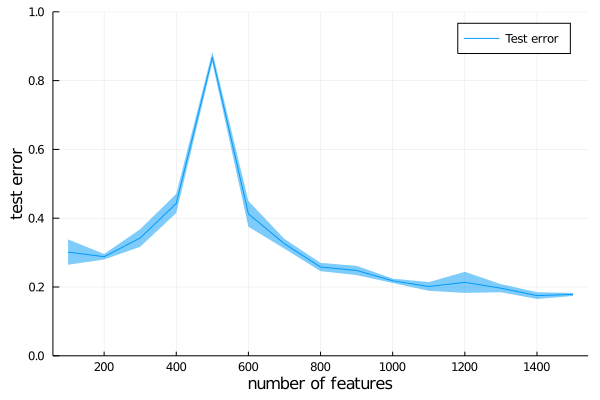

In [12]:
plot(ds,1 .- mean_acc_back,ribbon=std_acc_back,label="Test error")
ylims!((0.0, 1.0))
ylabel!("test error")
xlabel!("number of features")